# Import Libraries

In [37]:
!pip install -r requirements.txt -q

/Users/hedegaard/Documents/M3-TWITTERPROJECT/DDBMS-Submission/.conda/lib/python3.12/pty.py:95: DeprecationWarning:

This process (pid=9709) is multi-threaded, use of forkpty() may lead to deadlocks in the child.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [38]:
# Datahandling
import requests
import os
import numpy as np
import pandas as pd
import seaborn as sns

# Network analysis
from typing import List, Optional
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
from community import community_louvain
import plotly.graph_objects as go
import random
from collections import defaultdict

# Model prediction
from setfit import SetFitModel, SetFitTrainer
from sklearn.metrics import classification_report

# Gradio deployment
import gradio as gr


# Data

In [39]:
# Data import: 
data = pd.read_csv('detection_data.csv')

In [40]:
data.head()

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User ID         50000 non-null  int64 
 1   Username        50000 non-null  object
 2   Tweet           50000 non-null  object
 3   Retweet Count   50000 non-null  int64 
 4   Mention Count   50000 non-null  int64 
 5   Follower Count  50000 non-null  int64 
 6   Verified        50000 non-null  bool  
 7   Bot Label       50000 non-null  int64 
 8   Location        50000 non-null  object
 9   Created At      50000 non-null  object
 10  Hashtags        41659 non-null  object
dtypes: bool(1), int64(5), object(5)
memory usage: 3.9+ MB


# Network Analysis

In [ ]:
# data sampling? 
# data = data.sample(n=1000, random_state=42)

In [42]:
!pip install pyvis spacy

/Users/hedegaard/Documents/M3-TWITTERPROJECT/DDBMS-Submission/.conda/lib/python3.12/pty.py:95: DeprecationWarning:

This process (pid=9709) is multi-threaded, use of forkpty() may lead to deadlocks in the child.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches: 100%|██████████| 1563/1563 [00:26<00:00, 58.52it/s]
/Users/hedegaard/Documents/M3-TWITTERPROJECT/DDBMS-Submission/.conda/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=9709) is multi-threaded, use of fork() may lead to deadlocks in the child.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
To disable th

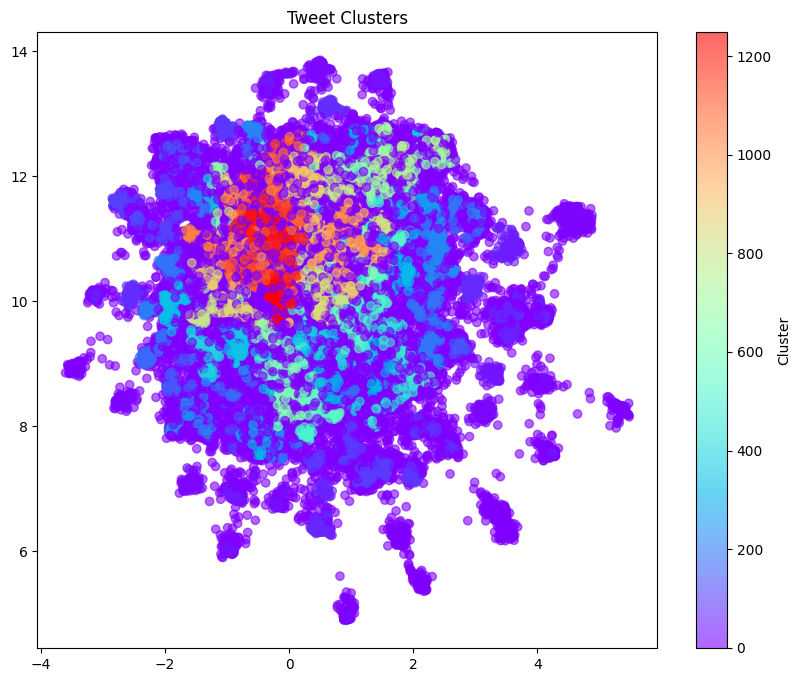


Cluster 0 examples:
4                         Animal sign six data good or.
15    Would mention respond because when break miss ...
86    Spend their fact myself amount trial late add ...
Name: Tweet, dtype: object

Cluster 1 examples:
229    Agent glass perhaps away world success politic...
351    Whom cut admit civil glass most finally forget...
430          Mother war glass development including end.
Name: Tweet, dtype: object

Cluster 2 examples:
1041          Realize rest person school gas clear teach.
1064                 Exist there whose alone someone gas.
1070    Behind continue tell give bring weight authori...
Name: Tweet, dtype: object

Cluster 3 examples:
208    Memory move forget oil western order wait whet...
422    Close oil network strategy somebody trade ther...
579    Oil impact wrong nearly crime water finally mo...
Name: Tweet, dtype: object

Cluster 4 examples:
2023     Peace husband wish nice hair avoid dark perhap...
26762    Mouth including personal color hair

In [44]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt

# 1. Load og forbered data
# Antager at 'data' indeholder en 'Tweet' kolonne

# 2. Transformer tekst til embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # Hurtig og effektiv model
embeddings = model.encode(data['Tweet'].tolist(), show_progress_bar=True)

# 3. Reducer dimensioner med UMAP
umap_embeddings = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine'
).fit_transform(embeddings)

# 4. Cluster med HDBSCAN
clusters = hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=5,
    metric='euclidean'
).fit_predict(umap_embeddings)

# 5. Tilføj resultater til dataframe
data['Cluster'] = clusters

# 6. Visualiser
plt.figure(figsize=(10, 8))
plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=clusters,
    cmap='rainbow',
    alpha=0.6
)
plt.title('Tweet Clusters')
plt.colorbar(label='Cluster')
plt.show()

# 7. Vis eksempler fra hver cluster
for cluster in set(clusters):
    if cluster != -1:  # Skip noise cluster
        print(f"\nCluster {cluster} examples:")
        print(data[data['Cluster'] == cluster]['Tweet'].head(3))

In [47]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import plotly.express as px
import plotly.io as pio

# Sæt standard renderer til browser
pio.renderers.default = "browser"

# Antager at 'data' indeholder en 'Tweet' kolonne

# Transformer tekst til embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(data['Tweet'].tolist(), show_progress_bar=True)

# Reducer dimensioner med UMAP
umap_embeddings = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine'
).fit_transform(embeddings)

# Cluster med HDBSCAN
clusters = hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=5,
    metric='euclidean'
).fit_predict(umap_embeddings)

# Opret DataFrame til plotting
plot_df = pd.DataFrame({
    'UMAP1': umap_embeddings[:, 0],
    'UMAP2': umap_embeddings[:, 1],
    'Cluster': clusters,
    'Tweet': data['Tweet']
})

# Lav interaktiv visualisering
fig = px.scatter(
    plot_df,
    x='UMAP1',
    y='UMAP2',
    color='Cluster',
    hover_data=['Tweet'],
    title='Tweet Clusters'
)

# Gem som HTML-fil
fig.write_html("tweet_clusters.html")

# Vis i browser
fig.show()

Batches: 100%|██████████| 1563/1563 [00:29<00:00, 52.73it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import plotly.express as px
import plotly.io as pio
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sæt standard renderer til browser
pio.renderers.default = "browser"

def identify_themes(data, clusters, n_themes=5):
    # Funktion til at identificere overordnede temaer
    def get_cluster_text(cluster_id):
        return ' '.join(data[clusters == cluster_id]['Tweet'])
    
    # Få unikke clusters (ignorer støj-cluster -1)
    unique_clusters = sorted(list(set(clusters[clusters != -1])))
    
    # Lav TF-IDF for hver cluster
    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
    cluster_texts = [get_cluster_text(c) for c in unique_clusters]
    tfidf_matrix = tfidf.fit_transform(cluster_texts)
    
    # Beregn similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    # Gruppér clusters i temaer baseret på similarity
    themes = {}
    theme_id = 0
    assigned_clusters = set()
    
    for i in range(len(unique_clusters)):
        if unique_clusters[i] not in assigned_clusters:
            # Start nyt tema
            theme_clusters = [unique_clusters[i]]
            assigned_clusters.add(unique_clusters[i])
            
            # Find relaterede clusters
            similarities = similarity_matrix[i]
            related_clusters = [(unique_clusters[j], similarities[j]) 
                              for j in range(len(unique_clusters))
                              if unique_clusters[j] not in assigned_clusters
                              and similarities[j] > 0.3]  # Similarity threshold
            
            # Tilføj relaterede clusters til tema
            for cluster, _ in sorted(related_clusters, key=lambda x: x[1], reverse=True):
                theme_clusters.append(cluster)
                assigned_clusters.add(cluster)
            
            # Gem tema
            themes[f"Theme_{theme_id}"] = theme_clusters
            theme_id += 1
    
    return themes

# Transformer tekst til embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(data['Tweet'].tolist(), show_progress_bar=True)

# Reducer dimensioner med UMAP
umap_embeddings = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine'
).fit_transform(embeddings)

# Cluster med HDBSCAN
clusters = hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=5,
    metric='euclidean'
).fit_predict(umap_embeddings)

# Identificer temaer
themes = identify_themes(data, clusters)

# Tilføj tema information til data
theme_mapping = {}
for theme_name, theme_clusters in themes.items():
    for cluster in theme_clusters:
        theme_mapping[cluster] = theme_name

# Opret DataFrame til plotting
plot_df = pd.DataFrame({
    'UMAP1': umap_embeddings[:, 0],
    'UMAP2': umap_embeddings[:, 1],
    'Cluster': clusters,
    'Tweet': data['Tweet']
})

# Tilføj tema kolonne
plot_df['Theme'] = plot_df['Cluster'].map(
    lambda x: theme_mapping.get(x, 'Noise') if x != -1 else 'Noise'
)

# Lav to visualiseringer

In [48]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import plotly.express as px
import plotly.io as pio
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sæt standard renderer til browser
pio.renderers.default = "browser"

def identify_themes(data, clusters, n_themes=5):
    # Funktion til at identificere overordnede temaer
    def get_cluster_text(cluster_id):
        return ' '.join(data[clusters == cluster_id]['Tweet'])
    
    # Få unikke clusters (ignorer støj-cluster -1)
    unique_clusters = sorted(list(set(clusters[clusters != -1])))
    
    # Lav TF-IDF for hver cluster
    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
    cluster_texts = [get_cluster_text(c) for c in unique_clusters]
    tfidf_matrix = tfidf.fit_transform(cluster_texts)
    
    # Beregn similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    # Gruppér clusters i temaer baseret på similarity
    themes = {}
    theme_id = 0
    assigned_clusters = set()
    
    for i in range(len(unique_clusters)):
        if unique_clusters[i] not in assigned_clusters:
            # Start nyt tema
            theme_clusters = [unique_clusters[i]]
            assigned_clusters.add(unique_clusters[i])
            
            # Find relaterede clusters
            similarities = similarity_matrix[i]
            related_clusters = [(unique_clusters[j], similarities[j]) 
                              for j in range(len(unique_clusters))
                              if unique_clusters[j] not in assigned_clusters
                              and similarities[j] > 0.3]  # Similarity threshold
            
            # Tilføj relaterede clusters til tema
            for cluster, _ in sorted(related_clusters, key=lambda x: x[1], reverse=True):
                theme_clusters.append(cluster)
                assigned_clusters.add(cluster)
            
            # Gem tema
            themes[f"Theme_{theme_id}"] = theme_clusters
            theme_id += 1
    
    return themes

# Transformer tekst til embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(data['Tweet'].tolist(), show_progress_bar=True)

# Reducer dimensioner med UMAP
umap_embeddings = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine'
).fit_transform(embeddings)

# Cluster med HDBSCAN
clusters = hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=5,
    metric='euclidean'
).fit_predict(umap_embeddings)

# Identificer temaer
themes = identify_themes(data, clusters)

# Tilføj tema information til data
theme_mapping = {}
for theme_name, theme_clusters in themes.items():
    for cluster in theme_clusters:
        theme_mapping[cluster] = theme_name

# Opret DataFrame til plotting
plot_df = pd.DataFrame({
    'UMAP1': umap_embeddings[:, 0],
    'UMAP2': umap_embeddings[:, 1],
    'Cluster': clusters,
    'Tweet': data['Tweet']
})

# Tilføj tema kolonne
plot_df['Theme'] = plot_df['Cluster'].map(
    lambda x: theme_mapping.get(x, 'Noise') if x != -1 else 'Noise'
)

# Lav to visualiseringer
# Lav to visualiseringer
# 1. Cluster visualisering
fig_clusters = px.scatter(
    plot_df,
    x='UMAP1',
    y='UMAP2',
    color='Cluster',
    hover_data=['Tweet'],
    title='Tweet Clusters',
    template='plotly_white'
)

# 2. Theme visualisering
fig_themes = px.scatter(
    plot_df,
    x='UMAP1',
    y='UMAP2',
    color='Theme',
    hover_data=['Tweet', 'Cluster'],
    title='Tweet Themes',
    template='plotly_white'
)

# Tilføj tema statistik
theme_stats = pd.DataFrame({
    'Theme': plot_df['Theme'].value_counts().index,
    'Count': plot_df['Theme'].value_counts().values,
    'Percent': (plot_df['Theme'].value_counts(normalize=True) * 100).round(2)
})

# Få eksempel tweets for hvert tema
def get_theme_examples(df, theme, n=3):
    return df[df['Theme'] == theme]['Tweet'].sample(min(n, len(df[df['Theme'] == theme]))).tolist()

theme_examples = {theme: get_theme_examples(plot_df, theme) 
                 for theme in plot_df['Theme'].unique()}

# Print tema analyse
print("\nTheme Analysis:")
print("===============")
print(theme_stats)
print("\nExample Tweets per Theme:")
print("========================")
for theme, examples in theme_examples.items():
    print(f"\n{theme}:")
    for i, example in enumerate(examples, 1):
        print(f"{i}. {example[:100]}...")

# Gem visualiseringer
fig_clusters.write_html("tweet_clusters.html")
fig_themes.write_html("tweet_themes.html")

# Vis i browser
fig_clusters.show()
fig_themes.show()

# Gem detaljeret analyse til CSV
detailed_analysis = pd.DataFrame({
    'Tweet': plot_df['Tweet'],
    'Cluster': plot_df['Cluster'],
    'Theme': plot_df['Theme'],
    'UMAP1': plot_df['UMAP1'],
    'UMAP2': plot_df['UMAP2']
})
detailed_analysis.to_csv('tweet_analysis.csv', index=False)

# Lav en sammenfatning af temaer og deres clusters
theme_summary = {}
for theme, clusters in themes.items():
    cluster_tweets = plot_df[plot_df['Cluster'].isin(clusters)]['Tweet']
    
    # Få top ord for dette tema
    vectorizer = TfidfVectorizer(max_features=10, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(cluster_tweets)
    top_words = vectorizer.get_feature_names_out()
    
    theme_summary[theme] = {
        'Clusters': clusters,
        'Tweet Count': len(cluster_tweets),
        'Top Words': top_words.tolist()
    }

# Print tema sammenfatning
print("\nTheme Summary:")
print("=============")
for theme, info in theme_summary.items():
    print(f"\n{theme}:")
    print(f"Clusters: {info['Clusters']}")
    print(f"Tweet Count: {info['Tweet Count']}")
    print(f"Top Words: {', '.join(info['Top Words'])}")

# Gem tema sammenfatning
theme_summary_df = pd.DataFrame.from_dict(theme_summary, orient='index')
theme_summary_df.to_csv('theme_summary.csv')

Batches: 100%|██████████| 1563/1563 [00:28<00:00, 55.11it/s]



Theme Analysis:
               Theme  Count  Percent
Theme                               
Noise          Noise  16648    33.30
Theme_10    Theme_10   4579     9.16
Theme_7      Theme_7   1870     3.74
Theme_2      Theme_2    812     1.62
Theme_54    Theme_54    656     1.31
...              ...    ...      ...
Theme_183  Theme_183      5     0.01
Theme_230  Theme_230      5     0.01
Theme_242  Theme_242      5     0.01
Theme_408  Theme_408      5     0.01
Theme_344  Theme_344      5     0.01

[694 rows x 3 columns]

Example Tweets per Theme:

Theme_35:
1. Structure toward prevent foreign artist marriage....
2. Better training marriage news chair anything stuff thing outside option during who....
3. Wife low compare suffer like another on drop season....

Theme_10:
1. Suddenly the thank life will mind....
2. Quickly development market feeling media body decade though....
3. Cultural may truth wear interest force....

Theme_122:
1. Cut animal home forward field gas call draw will beat b

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Theme Summary:

Theme_0:
Clusters: [np.int64(0)]
Tweet Count: 373
Top Words: business, choose, face, government, grow, happen, modern, organization, scene, skin

Theme_1:
Clusters: [np.int64(1)]
Tweet Count: 321
Top Words: bit, claim, environmental, gun, help, line, military, notice, poor, rule

Theme_2:
Clusters: [np.int64(2), np.int64(9)]
Tweet Count: 812
Top Words: animal, argue, building, dog, explain, hand, million, result, station, total

Theme_3:
Clusters: [np.int64(3)]
Tweet Count: 420
Top Words: animal, drug, energy, enter, hot, open, push, single, sister, time

Theme_4:
Clusters: [np.int64(4)]
Tweet Count: 346
Top Words: book, box, glass, local, man, prove, rock, senior, service, success

Theme_5:
Clusters: [np.int64(5), np.int64(25), np.int64(16), np.int64(26)]
Tweet Count: 262
Top Words: american, begin, campaign, hair, half, option, pattern, resource, safe, site

Theme_6:
Clusters: [np.int64(6)]
Tweet Count: 242
Top Words: community, consider, economic, generation, reduce

In [49]:
!pip install nltk

/Users/hedegaard/Documents/M3-TWITTERPROJECT/DDBMS-Submission/.conda/lib/python3.12/pty.py:95: DeprecationWarning:

This process (pid=9709) is multi-threaded, use of forkpty() may lead to deadlocks in the child.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.9 MB/s eta 0:00:00a 0:00:01


In [55]:
import nltk
print(nltk.data.path)

['/Users/hedegaard/nltk_data', '/Users/hedegaard/Documents/M3-TWITTERPROJECT/DDBMS-Submission/.conda/nltk_data', '/Users/hedegaard/Documents/M3-TWITTERPROJECT/DDBMS-Submission/.conda/share/nltk_data', '/Users/hedegaard/Documents/M3-TWITTERPROJECT/DDBMS-Submission/.conda/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/Users/hedegaard/nltk_data']


In [56]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import plotly.express as px
import plotly.io as pio
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Download necessary NLTK data files
import nltk
import os

# Definer en specifik sti til NLTK data
nltk_data_path = os.path.expanduser('~/nltk_data')

# Download data til den specifikke sti
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('averaged_perceptron_tagger', download_dir=nltk_data_path)

# Tilføj stien til NLTK's søgesti
nltk.data.path.append(nltk_data_path)

def identify_theme_name(tweets):
    """Identificerer et passende navn til et tema baseret på tweet indhold"""
    # Kombinér alle tweets
    text = ' '.join(tweets)
    
    # Tokenize og fjern stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    words = [w for w in words if w.isalnum() and w not in stop_words]
    
    # Find mest almindelige ord
    word_freq = Counter(words)
    common_words = word_freq.most_common(5)
    
    # Vælg det mest frekvente substantiv som tema-navn
    for word, _ in common_words:
        pos = nltk.pos_tag([word])[0][1]
        if pos.startswith('NN'):  # Hvis ordet er et substantiv
            return word.capitalize()
    
    return common_words[0][0].capitalize()  # Fallback til mest almindelige ord

# Resten af din eksisterende kode indtil plot_df oprettes...

# Efter plot_df er oprettet:
themes = {}
for cluster_id in plot_df['Cluster'].unique():
    if cluster_id != -1:  # Ignorer støj
        cluster_tweets = plot_df[plot_df['Cluster'] == cluster_id]['Tweet']
        theme_name = identify_theme_name(cluster_tweets)
        themes[cluster_id] = theme_name

# Tilføj tema navne til DataFrame
plot_df['Theme'] = plot_df['Cluster'].map(
    lambda x: themes.get(x, 'Noise') if x != -1 else 'Noise'
)

# Opdater visualiseringen
fig = px.scatter(
    plot_df,
    x='UMAP1',
    y='UMAP2',
    color='Theme',
    hover_data=['Tweet'],
    title='Tweet Themes'
)

# Gem og vis plot
fig.write_html("tweet_themes.html")
fig.show()

# Print tema statistik
print("\nTheme Analysis:")
print("===============")
for theme in themes.values():
    count = len(plot_df[plot_df['Theme'] == theme])
    print(f"{theme}: {count} tweets")

[nltk_data] Downloading package punkt to /Users/hedegaard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hedegaard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hedegaard/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/hedegaard/nltk_data'
    - '/Users/hedegaard/Documents/M3-TWITTERPROJECT/DDBMS-Submission/.conda/nltk_data'
    - '/Users/hedegaard/Documents/M3-TWITTERPROJECT/DDBMS-Submission/.conda/share/nltk_data'
    - '/Users/hedegaard/Documents/M3-TWITTERPROJECT/DDBMS-Submission/.conda/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/Users/hedegaard/nltk_data'
    - '/Users/hedegaard/nltk_data'
**********************************************************************


# Machine Learning